# Model Interpretation for Yolo Multitasks

from: https://github.com/pytorch/captum/blob/master/tutorials/Resnet_TorchVision_Interpret.ipynb

The interpretation algorithms that are used in this notebook are `Integrated Gradients` (w/ and w/o noise tunnel),  `GradientShap`, and `Occlusion`. A noise tunnel allows to smoothen the attributions after adding gaussian noise to each input sample.

In [1]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms
import captum
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

import pandas as pd

# machine learning
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.models as models
from torchvision.datasets import ImageFolder
# plots
import matplotlib.pyplot as plt
import tkinter
plt.switch_backend('TkAgg')
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
import argparse
import os
import sys
from pathlib import Path
import pandas as pd

import torch
from tqdm import tqdm

from models.common import DetectMultiBackend
from utils.dataloaders import create_classification_dataloader, InfiniteDataLoader
from utils.general import LOGGER, Profile, check_img_size, check_requirements, colorstr, increment_path, print_args
from utils.torch_utils import select_device, smart_inference_mode
import pandas

## 1- Load the model


In [3]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


Loads pretrained Resnet model and sets it to eval mode

In [51]:
# model = torch.load("hybrid-226.pt", map_location=device)
# model = model.eval()
WEIGHTS_PATH = "hybrid-226.pt"
# model = torch.load(WEIGHTS_PATH, map_location=device)
# print(model)
# # cut the model so that we only keep the backbone and the classification head, we dont need the detection head
# cls_model = model['model'][:9].append(model['model'][25])
# # model = model.eval()
# # save the cls model
# WEIGHTS_CLS_PATH = "cls_model.pt"
# torch.save(cls_model, WEIGHTS_CLS_PATH)

model = DetectMultiBackend(WEIGHTS_PATH, device=device, dnn=False, fp16=False)
stride, pt, jit, engine = model.stride, model.pt, model.jit, model.engine
imgsz = check_img_size(512, s=stride)  # check image size
half = model.fp16  # FP16 supported on limited backends with CUDA

Fusing layers... 
YOLOv5s_mlt summary: 163 layers, 7697578 parameters, 0 gradients, 16.4 GFLOPs


In [43]:
# model['model']

In [44]:
# print(model)

In [8]:
model.device

'cpu'

In [9]:
model.__class__.__name__ = 'yolov5s_mlt_512'

## Load the data

In [11]:
VAL_PATH = '/Users/selimgilon/Desktop/exp32/'
PATH = f'{VAL_PATH}val_dataset.pth'
val_dataset = torch.load(PATH)

In [4]:
# !wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

In [5]:
# labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
# with open(labels_path) as json_data:
#     idx_to_labels = json.load(json_data)

Defines transformers and normalizing functions for the image.
It also loads an image from the `img/resnet/` folder that will be used for interpretation purposes.

In [80]:
transform = transforms.Compose([
 transforms.Resize([512,512]),
#  transforms.CenterCrop(224),
 transforms.ToTensor(),
])

from PIL import Image

# load image in RGB mode (png files contains additional alpha channel)
img = Image.open('/Users/selimgilon/Desktop/test.jpg').convert('RGB')
img_tensor = transform(img)
img_tensor /= 255.0
img_tensor = img_tensor.unsqueeze(0)
img_tensor.shape

torch.Size([1, 3, 512, 512])

In [81]:
class_names = ['dry', 'snowy', 'wet']
idx_to_labels = ['dry', 'snowy', 'wet']

Predict the class of the input image

In [82]:
y_test = model(img_tensor.to(device))
(pred, cls_pred) = y_test
y_softmaxed = torch.nn.functional.softmax(cls_pred, dim=1)
# print(y_softmaxed)
confidence, class_num = torch.max(y_softmaxed, 1)
predicted_label = class_names[class_num]
prediction_score = round(float(confidence[0]),3)
print('Predicted:', predicted_label, "with confidence: ", prediction_score)

Predicted: dry with confidence:  0.524


In [24]:
y_test = model(img_tensor.to(device))
(pred, cls_pred) = y_test
output = F.softmax(cls_pred, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = class_names[pred_label_idx]
# predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')


Predicted: dry ( 0.5237011313438416 )


In [91]:
pred_label_idx

tensor(0)

In [25]:
class_num = class_num.to(device)
img_tensor = img_tensor.to(device)

## 2- Gradient-based attribution

Let's compute attributions using Integrated Gradients and visualize them on the image. Integrated gradients computes the integral of the gradients of the output of the model for the predicted class `pred_label_idx` with respect to the input image pixels along the path from the black image to our input image.

In [38]:
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(img_tensor, target=pred_label_idx, n_steps=30)





Predicted: snowy ( 0.7288388013839722 )


Let's visualize the image and corresponding attributions by overlaying the latter on the image.

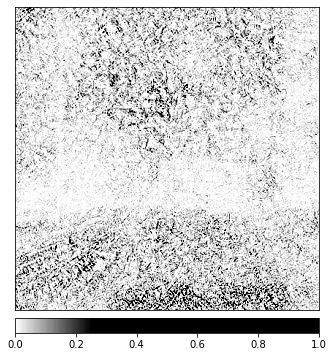

In [39]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img_tensor.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

Let us compute attributions using Integrated Gradients and smoothens them across multiple images generated by a <em>noise tunnel</em>. The latter adds gaussian noise with a std equals to one, 10 times (nt_samples=10) to the input. Ultimately, noise tunnel smoothens the attributions across `nt_samples` noisy samples using `smoothgrad_sq` technique. `smoothgrad_sq` represents the mean of the squared attributions across `nt_samples` samples.

In [45]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(img_tensor, nt_samples=1, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(img_tensor.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


RuntimeError: CUDA out of memory. Tried to allocate 134.00 MiB (GPU 0; 7.77 GiB total capacity; 5.90 GiB already allocated; 102.12 MiB free; 6.18 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Finally, let us use `GradientShap`, a linear explanation model which uses a distribution of reference samples (in this case two images) to explain predictions of the model. It computes the expectation of gradients for an input which was chosen randomly between the input and a baseline. The baseline is also chosen randomly from given baseline distribution.

In [49]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([img_tensor * 0, img_tensor * 1])

attributions_gs = gradient_shap.attribute(img_tensor,
                                          n_samples=10,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


RuntimeError: CUDA out of memory. Tried to allocate 106.00 MiB (GPU 0; 7.77 GiB total capacity; 5.97 GiB already allocated; 108.25 MiB free; 6.18 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## 3- Occlusion-based attribution

Now let us try a different approach to attribution. We can estimate which areas of the image are critical for the classifier's decision by occluding them and quantifying how the decision changes.

We run a sliding window of size 15x15 (defined via `sliding_window_shapes`) with a stride of 8 along both image dimensions (a defined via `strides`). At each location, we occlude the image with a baseline value of 0 which correspondes to a gray patch (defined via `baselines`).

**Note:** this computation might take more than one minute to complete, as the model is evaluated at every position of the sliding window.

In [92]:
def single_output_forward(out_ind):
    def forward(x):
        yhat = model(x)
        (yhat_det, yhat_cls) = yhat
        yhat_cls = yhat_cls.squeeze()
        print("yhat_cls", yhat_cls)
        print("dim", yhat_cls.shape)
        print("out ind", out_ind)
        print("yhat_cls[out_ind]", yhat_cls[out_ind])
        return yhat_cls[out_ind]
    return forward
with torch.no_grad():
    for i in range(5):
        fwd_fn = single_output_forward(i)
        # occlusion = Occlusion(fwd_fn)
        integrated_gradients = IntegratedGradients(fwd_fn)
        prediction_score, pred_label_idx = torch.topk(fwd_fn(img_tensor), 1)
        # print('Predicted class', pred_label_idx)
        # print('Prediction score', prediction_score)
        # attributions_occ = occlusion.attribute(img_tensor,
        #                                    strides = (3, 8, 8),
        #                                    target=0,
        #                                    sliding_window_shapes=(3, 15, 15),
        #                                    baselines=0)

    attributions_ig = integrated_gradients.attribute(img_tensor,n_steps=3, target=pred_label_idx)

yhat_cls tensor([ 1.00505, -1.28032,  0.79154])
dim torch.Size([3])
out ind 0
yhat_cls[out_ind] tensor(1.00505)
yhat_cls tensor([ 1.00505, -1.28032,  0.79154])
dim torch.Size([3])
out ind 1
yhat_cls[out_ind] tensor(-1.28032)
yhat_cls tensor([ 1.00505, -1.28032,  0.79154])
dim torch.Size([3])
out ind 2
yhat_cls[out_ind] tensor(0.79154)
yhat_cls tensor([ 1.00505, -1.28032,  0.79154])
dim torch.Size([3])
out ind 3


IndexError: index 3 is out of bounds for dimension 0 with size 3

In [88]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(img_tensor,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)


AttributeError: 'list' object has no attribute 'shape'

Let us visualize the attribution, focusing on the areas with positive attribution (those that are critical for the classifier's decision):

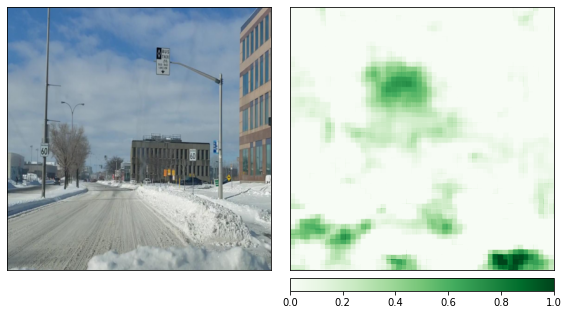

In [51]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(img_tensor.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )


The upper part of the goose, especially the beak, seems to be the most critical for the model to predict this class.

We can verify this further by occluding the image using a larger sliding window:

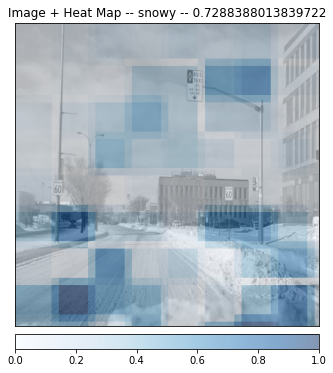

In [33]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(img_tensor,
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

# _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       np.transpose(img_tensor.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                       ["original_image", "heat_map"],
#                                       ["all", "positive"],
#                                       show_colorbar=True,
#                                       outlier_perc=2,
#                                      )
_ = viz.visualize_image_attr(
    np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(img_tensor.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    show_colorbar=True,
    method='blended_heat_map',
    outlier_perc=2,
    title="Image + Heat Map -- " + str(predicted_label) + " -- " + str(prediction_score.squeeze().item()),
    use_pyplot=True
    )

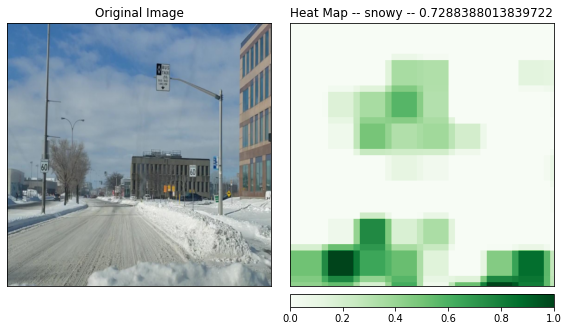

In [34]:
_ = viz.visualize_image_attr_multiple(
    np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(img_tensor.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    ["original_image", "heat_map"],
    ["all", "positive"],
    show_colorbar=True,
    outlier_perc=2,
    titles=["Original Image", "Heat Map -- " + str(predicted_label) + " -- " + str(prediction_score.squeeze().item())],

    )

In [93]:

model = models.resnet18(pretrained=True)
model = model.eval()

/Users/selimgilon/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Montreal/UdeM/Internship/E-Smart/code/yolov5_multitask/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/selimgilon/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Montreal/UdeM/Internship/E-Smart/code/yolov5_multitask/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/selimgilon/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [100]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json


zsh:1: command not found: wget


In [98]:

labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/selimgilon/.torch/models/imagenet_class_index.json'